## Simple statistical analysis of behavior

* accuracy
* slope/gamma
* bias 

can be explained by IQ,age, `group` etc. ?

simple regression models to find "raw" patterns in data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import os
import pingouin as pg

bids_folder = '/Users/mrenke/data/ds-dnumrisk'
params_folder = op.join(bids_folder,'derivatives/phenotype')

sns.set_context('talk')

from utils import get_data

df= get_data(bids_folder,  include_var=['group', 'age'])
df['group'] = np.where(df['group'] == 0, 'control', 'dyscalc')

df['correct_answer_n2'] = np.where((df['n2'] > df['n1']), True, False)
df['correct'] = np.where((df['correct_answer_n2'] == df['chose_n2']), True, False)


/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


number of subjects found: 66
number of subjects in dataframe: 66
Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66],
           dtype='int64', name='subject')


In [26]:
import scipy.stats as stats
import statsmodels.formula.api as smf

iq_scores = pd.read_csv(op.join(params_folder, 'iq-scores_ids2.csv')).set_index('subject')
iq_scores['mean_iq_z'] = stats.zscore(iq_scores['mean_iq'])
#iq_scores.head()

In [25]:
df_part = df.reset_index(['run','trial_nr'], drop=True)[['group','age']]
df_part =df_part.reset_index().drop_duplicates().set_index('subject')
df_part['age_z'] = stats.zscore(df_part['age'])

#df_part.head()

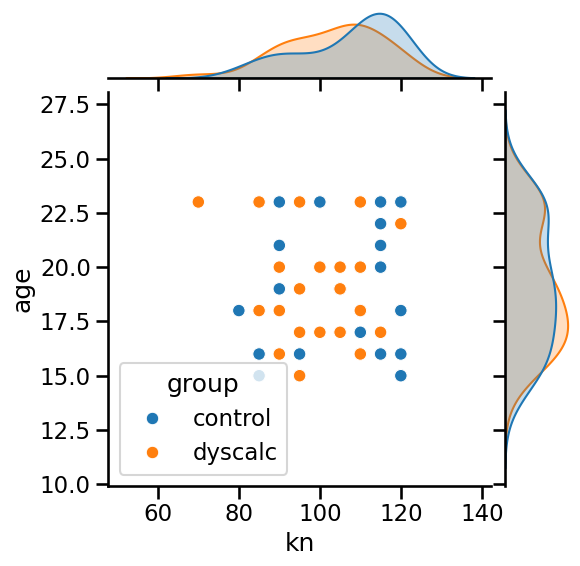

In [28]:
df_comb = df_part.join(iq_scores)
df_comb.sort_index(inplace=True)
sns.jointplot(data=df_comb, x='kn', y='age', hue='group')

In [4]:
# for y ~ mean_iq_z*age_z*group

def get_ols_predictions(res):
    reg_list = [ [0,1], [-1, 1], [-1, 1]]
    names=['group', 'mean_iq_z', 'age_z']
    fake_data = pd.MultiIndex.from_product(reg_list,names=names).to_frame().reset_index(drop=True)
    fake_data['mean_iq_z:group'] = fake_data['mean_iq_z'] * fake_data['group']
    fake_data['age_z:group'] = fake_data['age_z'] * fake_data['group']
    fake_data['mean_iq_z:age_z'] = fake_data['mean_iq_z'] * fake_data['age_z'] 
    fake_data['mean_iq_z:age_z:group'] = fake_data['mean_iq_z'] * fake_data['age_z'] * fake_data['group']

    coef = res.params
    coef.index = coef.index.str.replace('\[T.dyscalc\]', '')
    coef = coef.reindex(fake_data.columns)

    prediction = (fake_data * coef).sum(axis=1) + res.params['Intercept']
    prediction.index = pd.MultiIndex.from_product(reg_list,names=names)
    prediction = prediction.to_frame(name='prediction')

    return prediction

## accuracy
* IQ, age, group:age

In [31]:
# number range

temp = df.groupby(['subject','n1','group']).mean()

mod = smf.ols(formula='correct ~ n1*group', data=temp.reset_index())
res = mod.fit()
print(res.summary())

res:

n1:: coef -0.0059  p_val  0.000 

group ::   coef  -0.0239   p_val    0.240

n1:group  ::  coef  0.0003   p_val    0.868

--> 

In [156]:
# age
temp = df.groupby(['subject','group']).mean()

mod = smf.ols(formula='correct ~ age*group', data=temp.reset_index())
res = mod.fit()
#print(res.summary())

In [64]:
# sns.kdeplot(temp.reset_index(), x='mean_iq_z', hue='group', fill=True)


In [160]:
# all: mean_iq_z*age_z*group
temp = df.groupby(['subject','group']).mean().join(iq_scores).join(df_part['age_z'])
tmp = temp#.drop(46)

mod = smf.ols(formula='correct ~ mean_iq_z*age_z*group', data=tmp.reset_index())
res = mod.fit()
#print(res.summary())


/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_2966/598880458.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  coef.index = coef.index.str.replace('\[T.dyscalc\]', '')


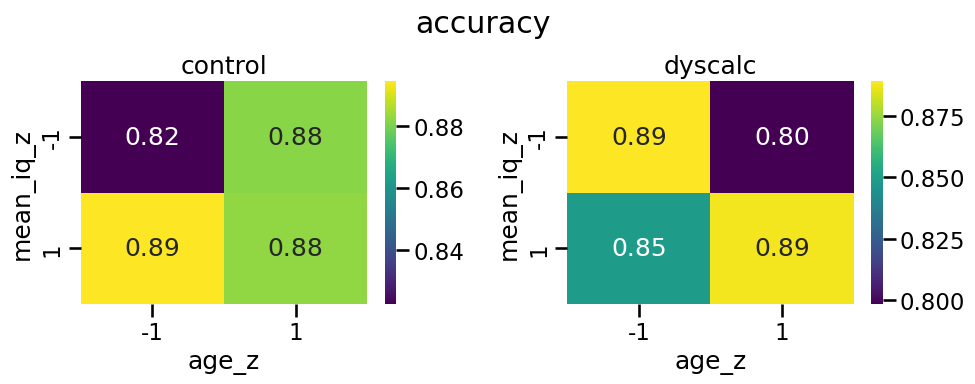

In [161]:
prediction = get_ols_predictions(res)
reshaped_data = prediction.unstack('group')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
for i, group in enumerate(reshaped_data.columns): # # Create a 2x2 heatmap for each group
    sns.heatmap(reshaped_data[group].unstack(), annot=True, fmt=".2f", cmap='viridis', ax=axes[i])
    group = 'dyscalc' if group == ('prediction', 1) else 'control'
    axes[i].set_title(f'{group}')
plt.tight_layout()
plt.suptitle('accuracy')
plt.subplots_adjust(top=0.8)
plt.show()

## Gamma
from probit model, but non hierachical to get "unbiased" subjectwise gammas

'chose_n2 ~ 0 + C(subject) + x:C(subject)'

In [5]:
gammas = pd.read_csv(op.join(params_folder, f'gamma-magjudge_probit-startSimple2.csv'))
gammas.set_index('subject', inplace=True)

In [6]:
gamma = gammas.join(df_part).join(iq_scores)  #, on='subject',how='left'
gamma.head()

,gamma,group,age,age_z,me,kn,mean_iq,mean_iq_z
subject,,,,,,,,
1,4.378226,control,19.0,-0.049754,120.0,105.0,112.5,1.042353
2,3.205958,dyscalc,17.0,-0.779482,100.0,95.0,97.5,-0.400905
3,2.701954,control,15.0,-1.509209,115.0,95.0,105.0,0.320724
4,4.681309,dyscalc,17.0,-0.779482,110.0,105.0,107.5,0.561267
5,3.369357,control,20.0,0.315110,90.0,115.0,102.5,0.080181


In [8]:
gamma_ = gamma#.drop(46)
mod = smf.ols(formula='gamma ~ age_z*mean_iq_z*group', data=gamma_.reset_index())
res = mod.fit()
#print(res.summary())

In [9]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  gamma   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     2.705
Date:                Wed, 29 May 2024   Prob (F-statistic):             0.0170
Time:                        14:48:56   Log-Likelihood:                -71.413
No. Observations:                  66   AIC:                             158.8
Df Residuals:                      58   BIC:                             176.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_5080/598880458.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  coef.index = coef.index.str.replace('\[T.dyscalc\]', '')


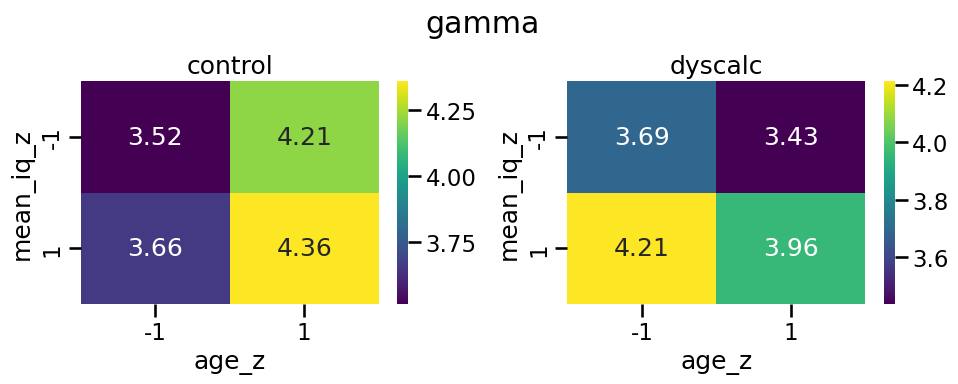

In [10]:
prediction = get_ols_predictions(res)
reshaped_data = prediction.unstack('group')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
for i, group in enumerate(reshaped_data.columns): # # Create a 2x2 heatmap for each group
    sns.heatmap(reshaped_data[group].unstack(), annot=True, fmt=".2f", cmap='viridis', ax=axes[i])
    group = 'dyscalc' if group == ('prediction', 1) else 'control'
    axes[i].set_title(f'{group}')
plt.tight_layout()
plt.suptitle('gamma')
plt.subplots_adjust(top=0.8)
plt.show()

>> for dyscalculia the age effect is reversed

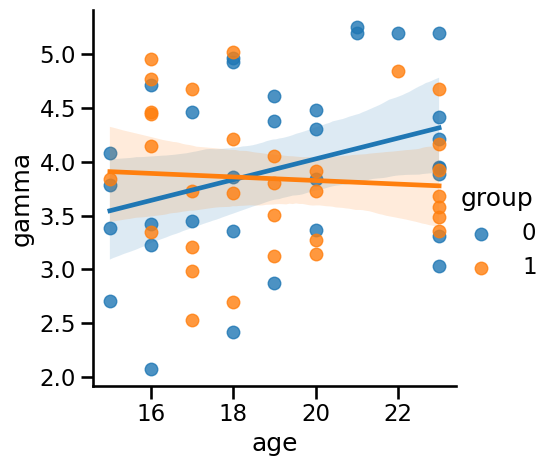

In [26]:
tmp = gamma.drop(46)
sns.lmplot(x='age', y='gamma', hue='group', data=tmp.reset_index())

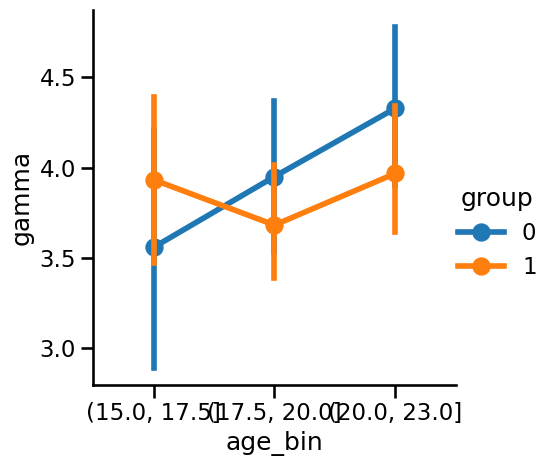

In [29]:
bins = [15, 17.5, 20, 23]
gamma['age_bin'] = pd.cut(gamma['age'], bins)

tmp = gamma.drop(46)
sns.catplot(x='age_bin', y='gamma', hue='group', data=tmp.reset_index(), kind='point')

### subwise BIAS :prop_chosen_n2 = beta * n1

In [39]:
# 
temp = df.groupby(['subject','n1','group']).mean()
mod = smf.ols(formula='chose_n2 ~ n1*group', data=temp.reset_index())
res = mod.fit()



In [40]:
# get subwise bias for subsequent analysis

import pingouin as pg

temp = df.groupby(['subject','n1','group']).mean().reset_index()

res = temp.groupby(['subject','group']).apply(lambda x: pg.linear_regression(x['n1'], x['chose_n2']))
res = res.drop(0, level=-1)
# sns.scatterplot(data=res, x='pval', y='coef', hue='group') #relationship between coef and significance

Text(0.5, 1.0, 'p=0.06')

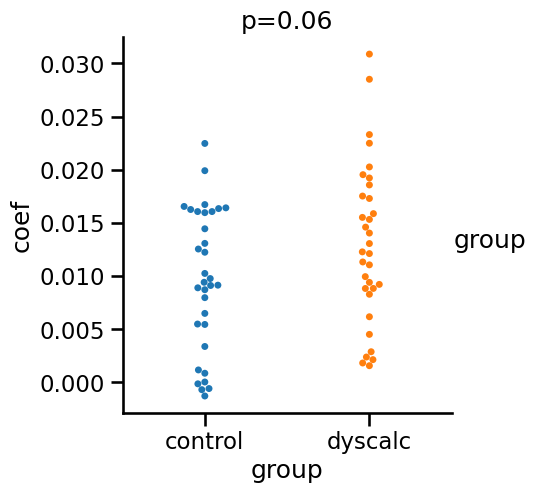

In [44]:
tmp = res['coef']

ttest = pg.ttest(tmp.xs('control', level=1), tmp.xs('dyscalc', level=1))
p_val = np.round(ttest['p-val'].values[0],3)   
sns.catplot(tmp.reset_index(), y='coef', x='group', hue='group', kind='swarm',errorbar=('ci', 95)) #x='n1',
plt.title(f'p={p_val}')